In [4]:
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# Physical variables

D = 4
packfrac = 0.2

# Non-physical parameters

sidepartnum = 5

accratio = 0.3
drmax = 1

density = packfrac / (np.pi**(D/2) * (1/2)**D / math.gamma(D/2 + 1))
partnum = sidepartnum ** D
boxlen = (partnum / density)**(1/D)
conf = np.array([
    (np.array(index) + 0.5) * density**(-1/D)
    for index in itertools.product(range(sidepartnum), repeat=D)
])

# Utils

def banner():
    print(f'''
____________________________________

            Monte-Carlo
____________________________________


D = {D}
N = {partnum}
d = {density}
L = {boxlen}

''')

# Energy

def partener(n):
    rn = conf[n]
    rvec = conf - rn
    rvec = rvec[np.arange(partnum) != n]
    rvec -= boxlen * np.round(rvec / boxlen)
    r = np.linalg.norm(rvec, axis=1)

    u = np.zeros(partnum - 1)
    dl = 65.85
    dT = 1.4737
    mask = r <= dl / (dl - 1)
    r = r[mask]
    u[mask] = ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT

    return np.sum(u)

def totener():
    energies = np.array([ partener(n) for n in range(partnum) ])
    return .5 * np.sum(energies)


# Motion

def boundcond():
    conf[np.any(conf > boxlen, axis=1)] %= boxlen

def movepart(n):
    v = np.random.randn(D)
    u = v / np.linalg.norm(v)
    dr = u * np.random.rand() * drmax
    conf[n] += dr
    conf[n] %= boxlen

# MonteCarlo sex

def mloglikelihood():
    pass

def mlogprior():
    pass

def adjustdr(ratio):
    global drmax
    drmax *= 1.05 if ratio > accratio else 0.95

def sampling(iterations):
    enerchain = []
    confchain = []

    energy = totener()
    accepteds = 0
    for tries in range(1, iterations + 1):
        n = np.random.randint(partnum)
        initpos = conf[n].copy()
        initener = partener(n)
        movepart(n)
        finalener = partener(n)

        diffener = finalener - initener

        if diffener < 0 or np.exp(-diffener) > np.random.rand():
            energy += diffener
            enerchain.append(energy)
            confchain.append(conf)
            accepteds += 1
            if accepteds % partnum == 1:
                enerchain.append(energy)
                confchain.append(conf.copy())
        else:
            conf[n] = initpos.copy()

        if tries % 100 == 0:
            ratio = accepteds / tries
            adjustdr(ratio)

        if tries % 10000 == 0:
            print(f'{tries}\t{energy}\t{drmax}\t{ratio}')

    return np.array(enerchain), np.array(confchain)

# Plots

def plothist(data, ax):
    counts, bins = np.histogram(data, bins=20)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    ax.bar(bin_centers, counts, width=bin_width, edgecolor='black')

def plot(conf, fn = None):
    D = conf.shape[1]
    fig, axs = plt.subplots(D, D, layout="constrained") 

    for i in range(D):
        for j in range(D):
            if j > i:
                axs[i, j].set_visible(False)
                
    for i in range(D):
        for j in range(D):
            if j < i:
                axs[i, j].set_title(f'Plane {i}{j}')
                axs[i, j].scatter(
                    conf[:, i],
                    conf[:, j],
                    marker='.',
                    alpha=0.5
                )
                
    for i in range(D):
        plothist(conf[:, i], axs[i, i])

    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()


def plotheat(conf):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = conf[:, 0]
    y = conf[:, 1]
    z = conf[:, 2]
    c = conf[:, 3]

    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

# main

banner()
enerchain, confchain = sampling(100_000)


____________________________________

            Monte-Carlo
____________________________________


D = 4
N = 625
d = 0.6484555753109618
L = 5.571856811747123


10000	63.980267759318046	0.35847095587357214	0.2963
20000	66.64255836925193	0.5217081974916401	0.2996
30000	62.458766909572425	0.562346849330684	0.2981
40000	54.277113839569594	0.44893533606022973	0.298075
50000	47.66553160339064	0.483905319104608	0.29774
60000	44.559058273974046	1.0509858232885003	0.3008166666666667
70000	48.238070951725305	0.22841381256890297	0.2993571428571429
80000	48.6669982208485	0.6060245425578599	0.3028125
90000	45.94737615578653	1.7771486489668633	0.30004444444444445
100000	51.22376902135149	1.915580296310778	0.29954


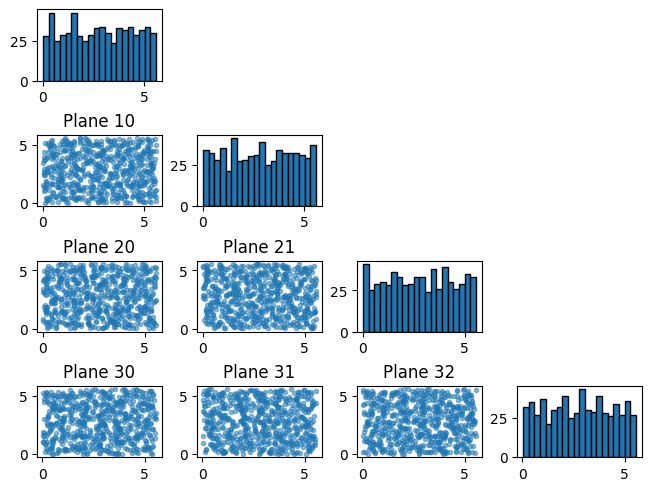

In [5]:
plot(conf)

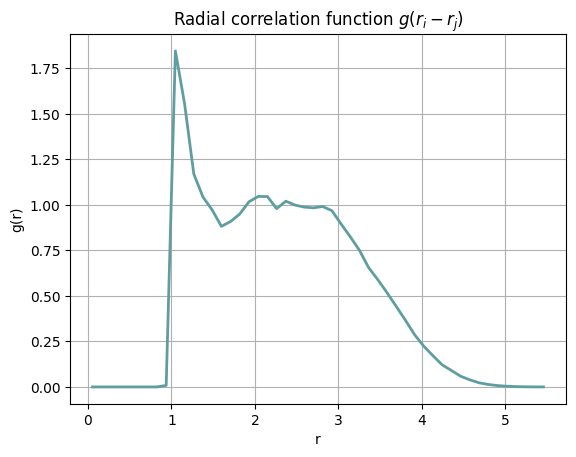

In [8]:

from scipy.spatial import distance_matrix

def periodic_distance_matrix(conf, L):
    """
    Calcula la matriz de distancias con condiciones periódicas usando mínima imagen.
    conf: array (N, d)
    L: escalar o array (d,)
    """
    delta = conf[:, np.newaxis, :] - conf[np.newaxis, :, :]
    delta -= L * np.round(delta / L)
    dist_mat = np.linalg.norm(delta, axis=-1)
    return dist_mat

def periodic_pdist_fast(conf, L):
    dist_mat = periodic_distance_matrix(conf, L)
    # Extrae los elementos de la parte superior del triángulo (sin la diagonal)
    i_upper = np.triu_indices(len(conf), k=1)
    return dist_mat[i_upper]
    
def estimador_gr(conf, bins=50, r_max=None, fn = None):
    N = conf.shape[0]
    d = conf.shape[1]
    
    dists = periodic_pdist_fast(conf ,boxlen)
    
    if r_max is None:
        r_max = np.max(dists)

    hist, bin_edges = np.histogram(dists, bins=bins, range=(0, r_max))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Volumen de las cáscaras esféricas en D dimensiones
    dr = bin_edges[1] - bin_edges[0]
    def volume_shell(r, dr, d):
        from scipy.special import gamma
        vol_d = (np.pi ** (d / 2)) / gamma(d / 2 + 1)
        return vol_d * ((r + dr/2) ** d - (r - dr/2) ** d)

    shell_volumes = np.array([volume_shell(r, dr, d) for r in bin_centers])
    
    V = boxlen**d

    if r_max is None:
        if L is not None:
            r_max = L / 2  # 🟢 Aquí va el PASO 3: evita distancias mayores a L/2
        else:
            r_max = np.max(dists)

    rho = N / V
    num_pairs = N * (N - 1) / 2  # porque estás usando pdist (pares únicos)
    gr = hist / (shell_volumes * num_pairs / V)

    plt.plot(bin_centers, gr, c='cadetblue', lw = 2)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.title("Radial correlation function $g(r_{i}-r_{j})$")
    plt.grid(True)
    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()

    return bin_centers, gr


r, gr = estimador_gr(conf, rma) #Estimador, devuelve distancias por bin y la función de correlación radial

In [10]:
pdist(conf)


array([1.0173807 , 2.02894782, 3.00558905, ..., 1.31338812, 2.2439179 ,
       1.0316163 ], shape=(49995000,))

In [1]:
np.save('conf', conf)

NameError: name 'np' is not defined

# MODELADO

Esto calcula parametros del potencial PHS para ajustar su coeficiente de virial hasta concidir con el de HS

In [4]:
from scipy.integrate import quad
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
D =  4
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)
print(B_HS)

def diff(dl):
    dT = 1.4737
    def u(r):
        if r > dl / (dl - 1):
            return 0
        return ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, dl / (dl -1 ))
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    
    return abs(B_HS - B_PHS)

x = np.arange(60, 70, 0.1)
y = [ diff(z) for z in x ]

2.4674011002723395


In [6]:
2* np.pi / 3

2.0943951023931953

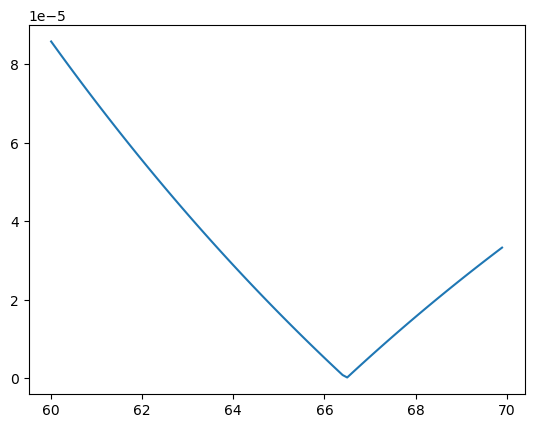

In [7]:
plt.plot(x,y)

In [8]:
4 * np.pi 

12.566370614359172

In [9]:
import emcee
import corner

100%|██████████| 3000/3000 [01:09<00:00, 43.46it/s]


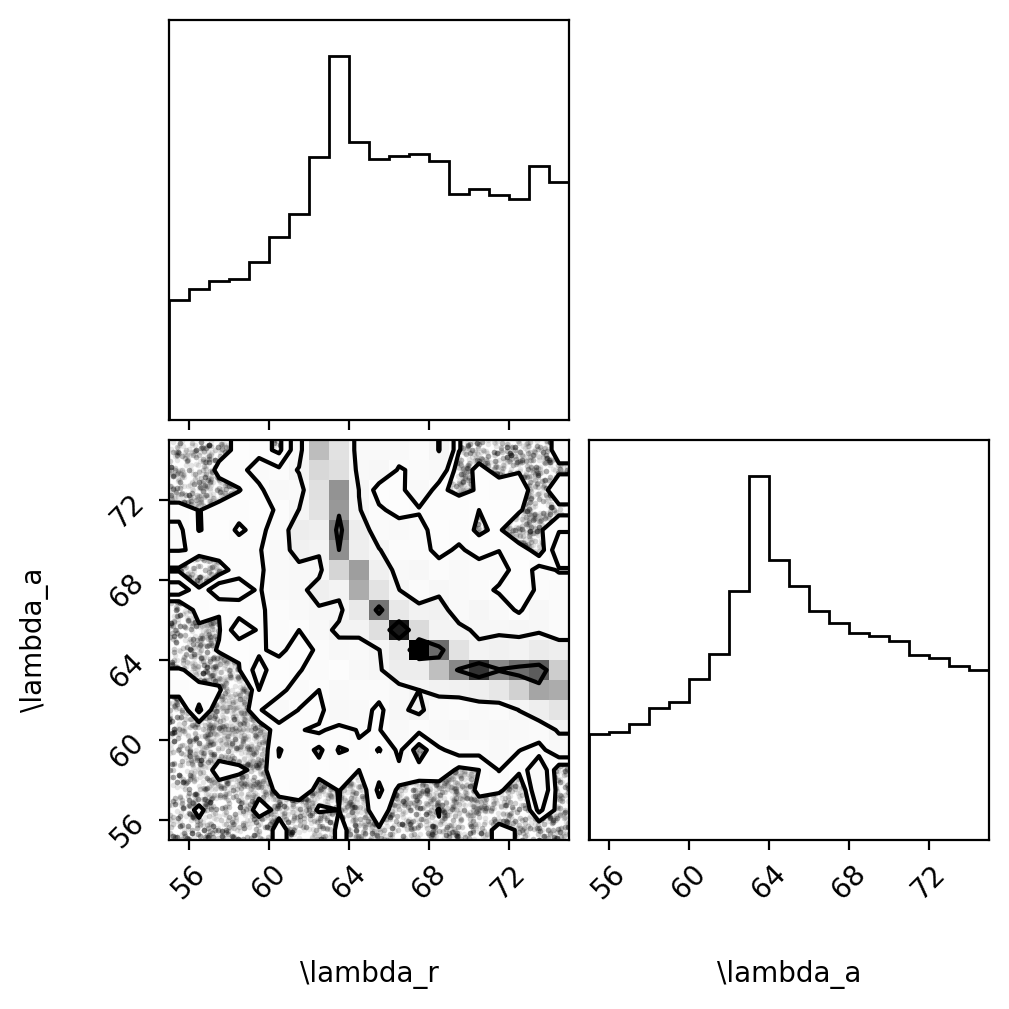

In [117]:
np.random.seed(42)
D = 4
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

def log_likelihood(theta):
    r, a = theta

    T = 1.4737
    e = 1 / T

    
    A = r / (r - a) * (r / a)**(a / (r - a))
    B = (r / a)**(1 / (r - a))
        
    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, B)
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    chi =  np.sum((B_HS - B_PHS)**2)
    return -0.5 * np.log10(chi)

def log_prior(theta):
    r, a = theta
    if 55 < r < 75 and 55 < a < 75:
        return 0.0 
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

ndim = 2           
nwalkers = 20
p0_r = np.random.normal(65, np.sqrt(5), nwalkers)
p0_a = np.random.normal(60, np.sqrt(5), nwalkers) 
p0 = np.column_stack([p0_r, p0_a])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 3000, progress=True)
samples = sampler.get_chain(discard=500, flat=True)

corner.corner(samples, labels=["\lambda_r", "\lambda_a"])
plt.show()

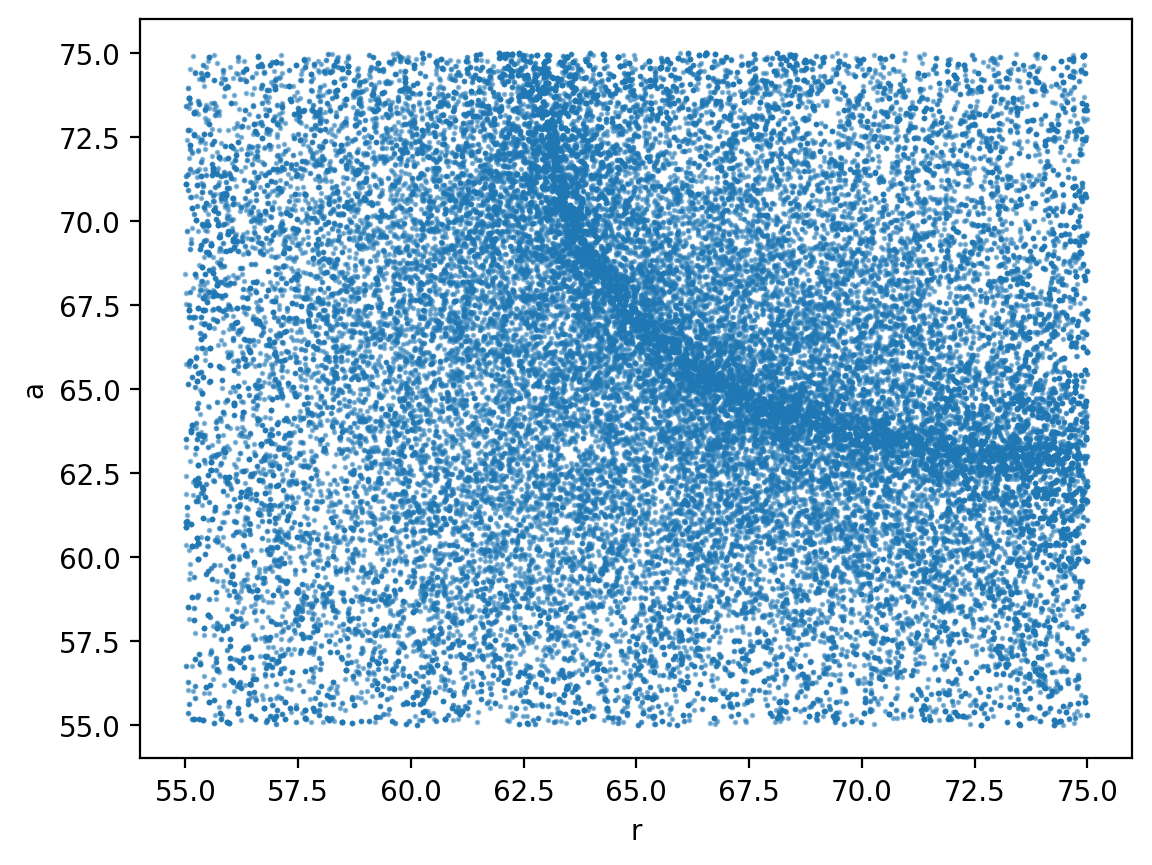

In [118]:
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel("r")
plt.ylabel("a")
plt.show()

In [119]:
param_names = [r'$\lambda_r$', r'$\lambda_a$']
mcsamples = MCSamples(samples = samples, names = param_names)
s = mcsamples.copy(settings={'mult_bias_correction_order':1,
                       #'smooth_scale_2D':0, 
                       'smooth_scale_1D':0.8})

Removed no burn in


In [120]:
mcsamples.getMeans()

array([65.89598893, 65.60141663])

<Figure size 1500x1500 with 0 Axes>

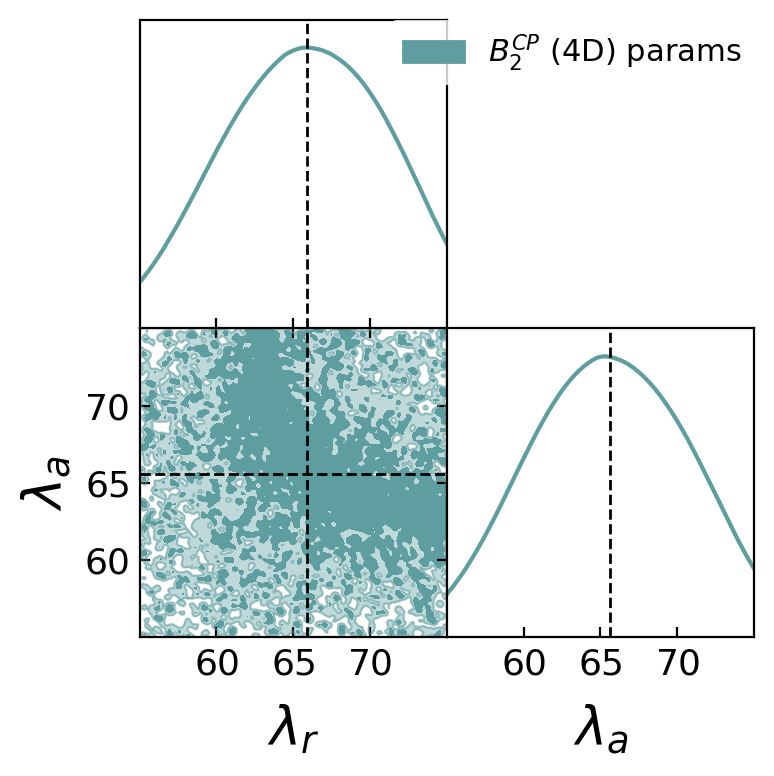

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import emcee
import getdist
import IPython
from getdist import plots, MCSamples


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = plots.get_subplot_plotter()
g.fig = plt.figure(figsize=(15, 15))
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.8  # Transparency for filled contours
#g.settings.linewidth = 1.5  # Width of contour lines
g.settings.axis_marker_color = 'k'
g.settings.legend_fontsize =  14#16 #18
g.settings.axes_labelsize = 22  #22
g.settings.axes_fontsize = 16 #16
g.settings.axis_marker_lw = 1


g.triangle_plot([s], filled=[True, True, True, True],
               contour_colors=['cadetblue'],figure_kwargs={"figsize": (15,15)},
                contour_lws = [1.5, 1.5, 1.5], contour_ls = ['-','-'],marker_args = ({'color':'k','lw' :  1}),
                #params = params,
               markers = [65.90, 65.60],
                #title_limit=0,
                legend_labels = [r'$B_2^{CP}$ (4D) params'],
                param_limits={r'$\lambda_r$':[55,75],r'$\lambda_a$':[55,75]}
                ,legend_loc = 'upper right')

#plt.suptitle(r'cosmo1 fits')
plt.savefig('lambda_a-lambda_r-phs_potential-4d', dpi=300, bbox_inches='tight')

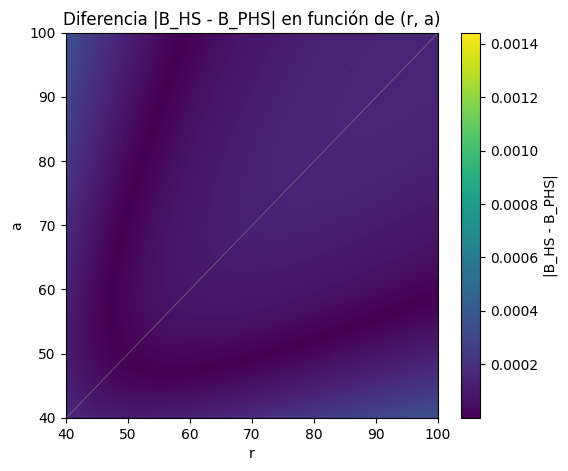

In [47]:
import numpy as np
import matplotlib.pyplot as plt

D = 3
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

# Definir el dominio
x = np.linspace(40, 100,1000)
y = np.linspace(40, 100, 1000)
X, Y = np.meshgrid(x, y)

def diff(r, a):
    if r == a:
        return np.nan  # evitar división por cero

    T = 1.4737
    e = 1 / T

    try:
        A = r / (r - a) * (r / a)**(a / (r - a))
        B = (r / a)**(1 / (r - a))
    except ZeroDivisionError:
        return np.nan

    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e

    try:
        integrand = lambda r_: (np.exp(-u(r_)) - 1) * r_**(D-1)
        result, _ = quad(integrand, 0, B)
        B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    except Exception:
        return np.nan

    return np.abs(B_HS - B_PHS)

# Vectorizar la función
vecdiff = np.vectorize(diff)

# Evaluar f(x, y), omitiendo la diagonal
Z = vecdiff(X, Y)
Z[X == Y] = np.nan  # opcional: quitar la diagonal x = y

# Graficar
plt.figure(figsize=(6, 5))
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='|B_HS - B_PHS|')
plt.xlabel('r')
plt.ylabel('a')
plt.title('Diferencia |B_HS - B_PHS| en función de (r, a)')
plt.show()

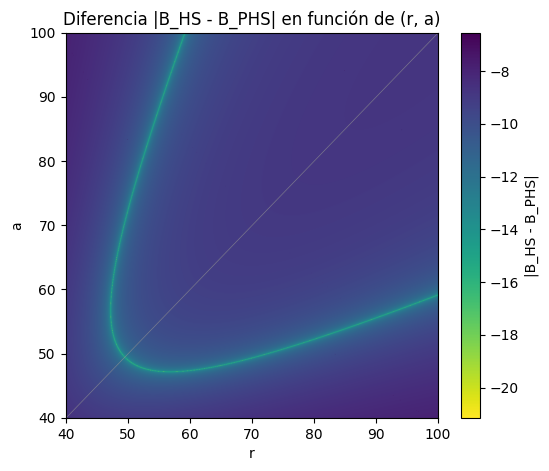

In [48]:
# Graficar
plt.figure(figsize=(6, 5))
plt.imshow(np.log(Z), extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', cmap='viridis_r', aspect='auto')
plt.colorbar(label='|B_HS - B_PHS|')
plt.xlabel('r')
plt.ylabel('a')
plt.title('Diferencia |B_HS - B_PHS| en función de (r, a)')
plt.show()

In [41]:
Z

array([[       nan, 0.0007506 , 0.00074093, ..., 0.00073012, 0.00073205,
        0.00073397],
       [0.0007506 ,        nan, 0.00073081, ..., 0.00071484, 0.00071676,
        0.00071868],
       [0.00074093, 0.00073081,        nan, ..., 0.00069981, 0.00070174,
        0.00070365],
       ...,
       [0.00073012, 0.00071484, 0.00069981, ...,        nan, 0.00015892,
        0.00015913],
       [0.00073205, 0.00071676, 0.00070174, ..., 0.00015892,        nan,
        0.00015938],
       [0.00073397, 0.00071868, 0.00070365, ..., 0.00015913, 0.00015938,
               nan]], shape=(200, 200))

In [51]:
idx_min = np.unravel_index(np.nanargmin(Z), Z.shape)

# Obtener las coordenadas correspondientes
x_min = X[idx_min]
y_min = Y[idx_min]
z_min = Z[idx_min]

print(f"Valor mínimo de Z: {z_min:.4f} en (x, y) = ({x_min:.4f}, {y_min:.4f})")

Valor mínimo de Z: 0.0000 en (x, y) = (64.9850, 48.1682)
